# Interaction between characters

In [1]:
import sys
sys.path.insert(1, '../src')

from book_entities import *
from book_entities_embeddings_getters import *

## Book entities

In [2]:
# cleaned entities
textually_close_merged_book_cleaned_entities, lax_merged_book_cleaned_entities = get_book_entities(
    f'../data/book_entities/grouped_token_cleaned.csv')

## Paragraphs

In [3]:
from bs4 import BeautifulSoup

In [4]:
# Reading the data inside the xml
# file to a variable under the name
# data
with open('../data/book/stendhal_rougenoir_xml.xml', 'r') as f:
	data = f.read()

In [5]:
# Passing the stored data inside
# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")

In [6]:
paragraphs = []
for tag in Bs_data.find_all('p') :
    if tag.name == 'p' and not ('rend' in tag.attrs) :
        paragraphs.append(tag.get_text())

### dialogue et narration

In [7]:
narration = []
temp_dialogue = []
for p in paragraphs :
    if isinstance(p, str) :
        if p[0] == '–' :
            temp_dialogue.append(p)
        else :
            if len(temp_dialogue)>0 :
                narration.append(' '.join(temp_dialogue))
                temp_dialogue=[]
            narration.append(p)
        

pour chaque paragraphe chercher si il contient une entité, puis regarder toutes les entités qu'il contient 



### narration

In [8]:
def process_paragraph(p) :
    
    pattern1 = r"""[,.;@#?!&$\s:–]+"""
    pattern2 = r"""[-'’_]"""

    p = re.sub(r'|'.join((pattern1, pattern2)),
               " ",          # and replace it with a single space
               p.replace('\xa0', ' '), flags=re.VERBOSE)
    return [i.lower() for i in p.split(' ')[:-1] if i.lower() not in french_stopwords]

In [9]:
def entity_in_paragraph(entity, paragraph):
    return [1 for address in entity.all_addresses if all(x.lower() in p for x in address.lower().split(' '))]

In [10]:
dict_interaction = {}
for paragraph in narration :
    p = process_paragraph(paragraph)
    paragraph_entities = [
        i for i in textually_close_merged_book_cleaned_entities if entity_in_paragraph(i, p)]
    
    if len(paragraph_entities)>=2 :
        key = frozenset(paragraph_entities)
        value = dict_interaction.get(key,[])
        value.append(p)
        dict_interaction[key] = value

In [11]:
len(dict_interaction)

199

## DataFrame of Interactions

In [12]:
entities = []
interactions = []
for k, v in dict_interaction.items() :
    entities.append([BookEntity.from_list_entity(ent).get_shortname() for ent in k])
    interactions.append(v)
    
interactions_df = pd.DataFrame({'entities':entities, 'interactions' : interactions})

In [13]:
interactions_df.head()

,entities,interactions
0,"[Abbé Julien Sorel, M Rênal]","[[attendez, point, trouver, france, jardins, p..."
1,"[M Rênal, Vicaire Maslon]","[[trouve, chose, reprendre, cours, fidelite, l..."
2,"[Mme Rênal, M Rênal]","[[jour, automne, m, rênal, promenait, cours, f..."
3,"[M Rênal, M Valenod, Abbé Chélan]","[[faits, commentés, exagérés, façons, agitaien..."
4,"[M Rênal, M Valenod]","[[reproches, m, rênal, m, valenod, directeur, ..."


In [14]:
interactions_df['nber_interactions']= interactions_df.interactions.apply(lambda x : len(x))
interactions_df.head()

,entities,interactions,nber_interactions
0,"[Abbé Julien Sorel, M Rênal]","[[attendez, point, trouver, france, jardins, p...",50
1,"[M Rênal, Vicaire Maslon]","[[trouve, chose, reprendre, cours, fidelite, l...",1
2,"[Mme Rênal, M Rênal]","[[jour, automne, m, rênal, promenait, cours, f...",12
3,"[M Rênal, M Valenod, Abbé Chélan]","[[faits, commentés, exagérés, façons, agitaien...",1
4,"[M Rênal, M Valenod]","[[reproches, m, rênal, m, valenod, directeur, ...",8


In [15]:
interactions_df = interactions_df.sort_values(by = 'nber_interactions', ascending = False)

### embeddings of interactions

In [16]:
model_name = 'flaubert/flaubert_base_cased' 

# Load pretrained model and tokenizer
flaubert, log = FlaubertModel.from_pretrained(model_name, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(model_name, do_lowercase=False)

def from_interaction_to_embeddings (list_interactions) :
    embeddings = []
    for interaction in list_interactions :
        token_ids = torch.tensor([flaubert_tokenizer.encode(interaction)])
        last_layer = flaubert(token_ids)[0][:,1:-1, :]

        # possibilité de faire d'autres opérations
        # embeddings.append(torch.mean(last_layer, dim = 1).detach().numpy()[0])
        embeddings.append(last_layer.detach().numpy())
    return embeddings

interactions_df['embeddings'] = interactions_df.interactions.apply(
    lambda x : from_interaction_to_embeddings(x))
                                                             

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
renal_sorel = interactions_df.iloc[0].embeddings

In [18]:
interactions_df.entities.head()

16              [Mme Rênal, Abbé Julien Sorel]
107         [Abbé Julien Sorel, Mole Mathilde]
0                 [Abbé Julien Sorel, M Rênal]
77               [Abbé Julien Sorel, M Pirard]
17     [Mme Rênal, Abbé Julien Sorel, M Rênal]
Name: entities, dtype: object

In [19]:
mole_sorel = interactions_df.iloc[1].embeddings

## PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
renal_sorel_pca = []
for emb in tqdm(renal_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 33.43it/s]


In [24]:
mole_sorel_pca = []
for emb in tqdm(mole_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    mole_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:02<00:00, 42.52it/s]


In [25]:
renal_m_sorel = interactions_df.iloc[2].embeddings
renal_m_sorel_pca = []
for emb in tqdm(renal_m_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_m_sorel_pca.append(components)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 42.92it/s]


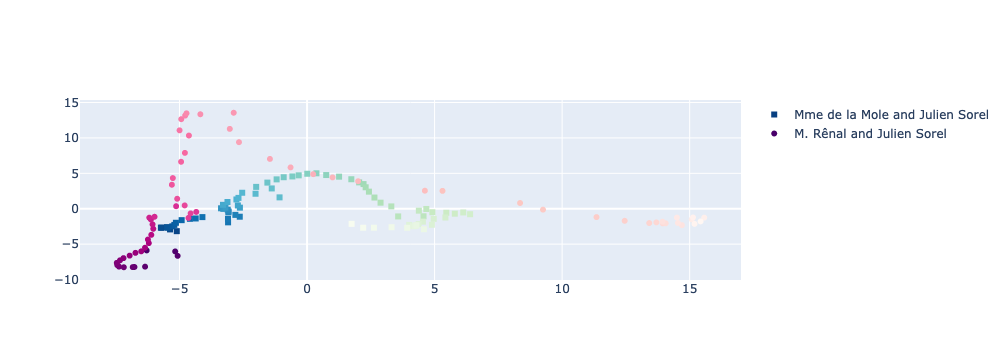

In [37]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=1)

mole_sorel_df = pd.DataFrame(mole_sorel_pca[0])
renal_m_sorel_df = pd.DataFrame(renal_m_sorel_pca[0])

fig.add_trace(
    go.Scatter(x = mole_sorel_df[0], y = mole_sorel_df[1], mode='markers', marker = dict (
        color=mole_sorel_df.index[::-1], colorscale = 'GnBu', symbol = 'square'), name = "Mme de la Mole and Julien Sorel"),
    row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = renal_m_sorel_df[0], y = renal_m_sorel_df[1], mode='markers', marker = dict (
        color=renal_m_sorel_df.index[::-1], colorscale = 'RdPu'), name = 'M. Rênal and Julien Sorel'),
    row = 1, col = 1)
fig.show()



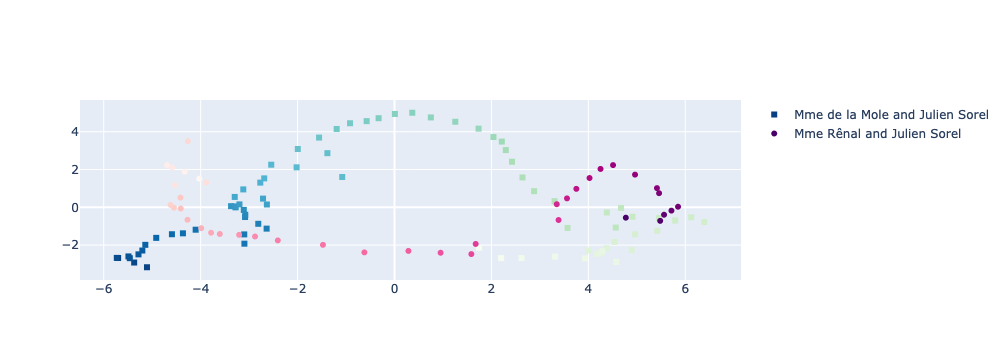

In [38]:
fig = make_subplots(rows=1, cols=1)

mole_sorel_df = pd.DataFrame(mole_sorel_pca[0])
renal_sorel_df = pd.DataFrame(renal_sorel_pca[0])

fig.add_trace(
    go.Scatter(x = mole_sorel_df[0], y = mole_sorel_df[1], mode='markers', marker = dict (
        color=mole_sorel_df.index[::-1], colorscale = 'GnBu', symbol = 'square'), name = "Mme de la Mole and Julien Sorel"),
    row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = renal_sorel_df[0], y = renal_sorel_df[1], mode='markers', marker = dict (
        color=renal_sorel_df.index[::-1], colorscale = 'RdPu'), name = 'Mme Rênal and Julien Sorel'),
    row = 1, col = 1)
fig.show()